In [3]:
!pip install statsmodels prophet xgboost scikit-learn matplotlib pandas numpy --quiet

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [21]:
import pandas as pd

df = pd.read_csv("household power consumption.csv")
print(df.columns)

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')


In [33]:
print("Train_data shape:", train_data.shape)
print("NaN count in Global_active_power:", train_data['Global_active_power'].isna().sum())
print(train_data['Global_active_power'].head(10))

Train_data shape: (0, 13)
NaN count in Global_active_power: 0
Series([], Freq: h, Name: Global_active_power, dtype: float64)


In [36]:
import pandas as pd

df = pd.read_csv("household power consumption.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Parse datetime correctly
df['timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['timestamp'])

# Set index
df.set_index('timestamp', inplace=True)

# Convert numeric columns
df = df.apply(pd.to_numeric, errors='coerce')

# Resample hourly and fill missing values instead of dropping
df = df.resample('h').mean().interpolate()

# Train-test split on Global_active_power
series = df['Global_active_power']
train_size = int(len(series) * 0.8)
train_data, test_data = series[:train_size], series[train_size:]

print("Train size:", train_data.shape)
print("Test size:", test_data.shape)

Train size: (13981,)
Test size: (3496,)


C:\Users\ait\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA MAE: 0.6884723099983387
ARIMA RMSE: 0.9020546091485153


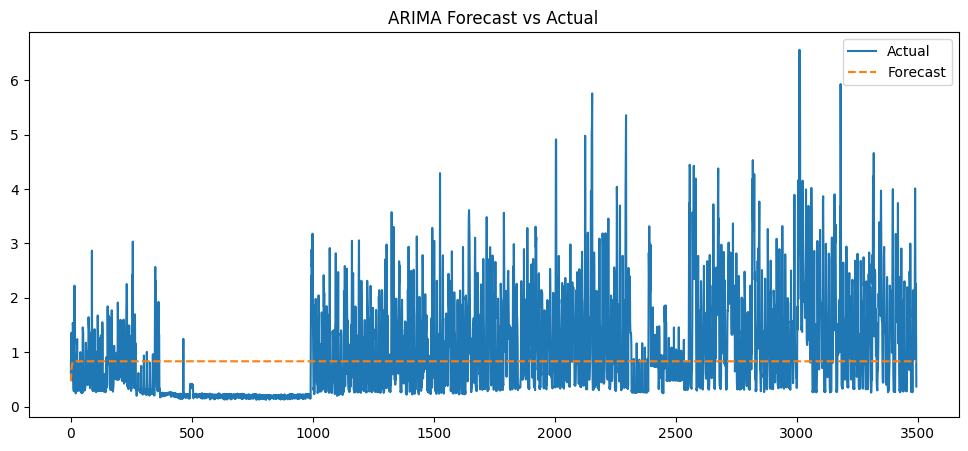

In [71]:

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load and preprocess
df = pd.read_csv("household power consumption.csv")
df.columns = df.columns.str.strip()
df['timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['timestamp'])
df.set_index('timestamp', inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.resample('h').mean().interpolate()

# Train-test split
series = df['Global_active_power']
train_size = int(len(series) * 0.8)
train_data, test_data = series[:train_size], series[train_size:]

# Fit ARIMA
arima_model = ARIMA(train_data, order=(1, 1, 1))
arima_fit = arima_model.fit()

# Forecast
arima_forecast = arima_fit.forecast(steps=len(test_data))

# ---- Evaluation ----
arima_mae = mean_absolute_error(test_data, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test_data, arima_forecast))
print("ARIMA MAE:", arima_mae)
print("ARIMA RMSE:", arima_rmse)

# Plot
plt.figure(figsize=(12,5))
plt.plot(test_data.values, label='Actual')
plt.plot(arima_forecast.values, label='Forecast', linestyle='dashed')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()

In [64]:
import pandas as pd

# Use comma instead of semicolon
df = pd.read_csv("household power consumption.csv", sep=",", low_memory=False)

# Check columns again
print(df.columns.tolist())

# Create datetime column
df["datetime"] = pd.to_datetime(
    df["Date"].astype(str).str.strip() + " " + df["Time"].astype(str).str.strip(),
    errors="coerce",
    dayfirst=True
)

print(df[["Date", "Time", "datetime"]].head())

['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
         Date      Time            datetime
0  16/12/2006  17:24:00 2006-12-16 17:24:00
1  16/12/2006  17:25:00 2006-12-16 17:25:00
2  16/12/2006  17:26:00 2006-12-16 17:26:00
3  16/12/2006  17:27:00 2006-12-16 17:27:00
4  16/12/2006  17:28:00 2006-12-16 17:28:00


C:\Users\ait\AppData\Local\Temp\ipykernel_396\493117886.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index("datetime")["global_active_power"].resample("H").mean().dropna().reset_index()
14:49:09 - cmdstanpy - INFO - Chain [1] start processing
14:49:19 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.6583947700678419
RMSE: 0.8289375549758805
Prophet MAE: 0.6583947700678419
Prophet RMSE: 0.8289375549758805


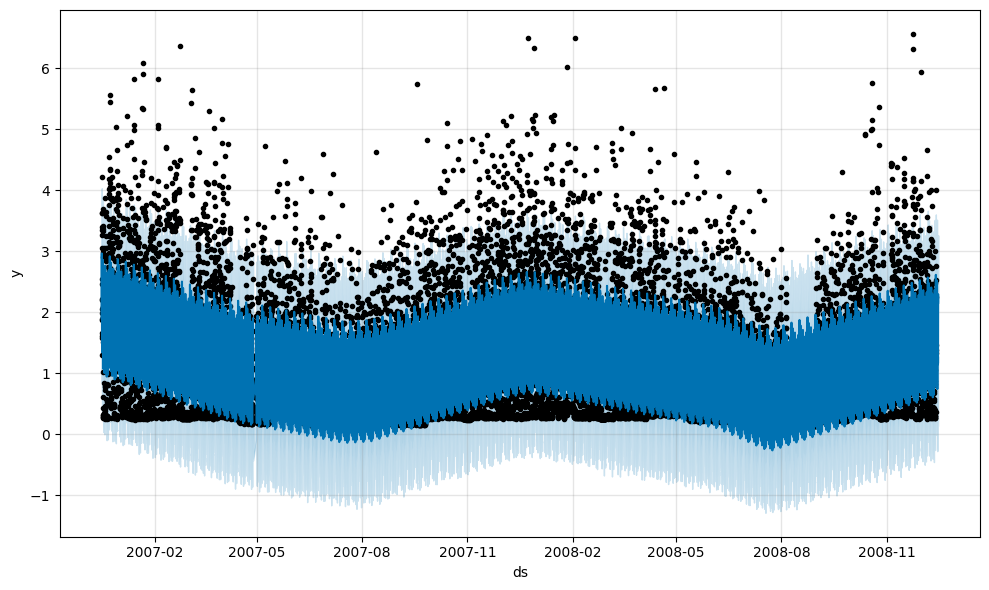

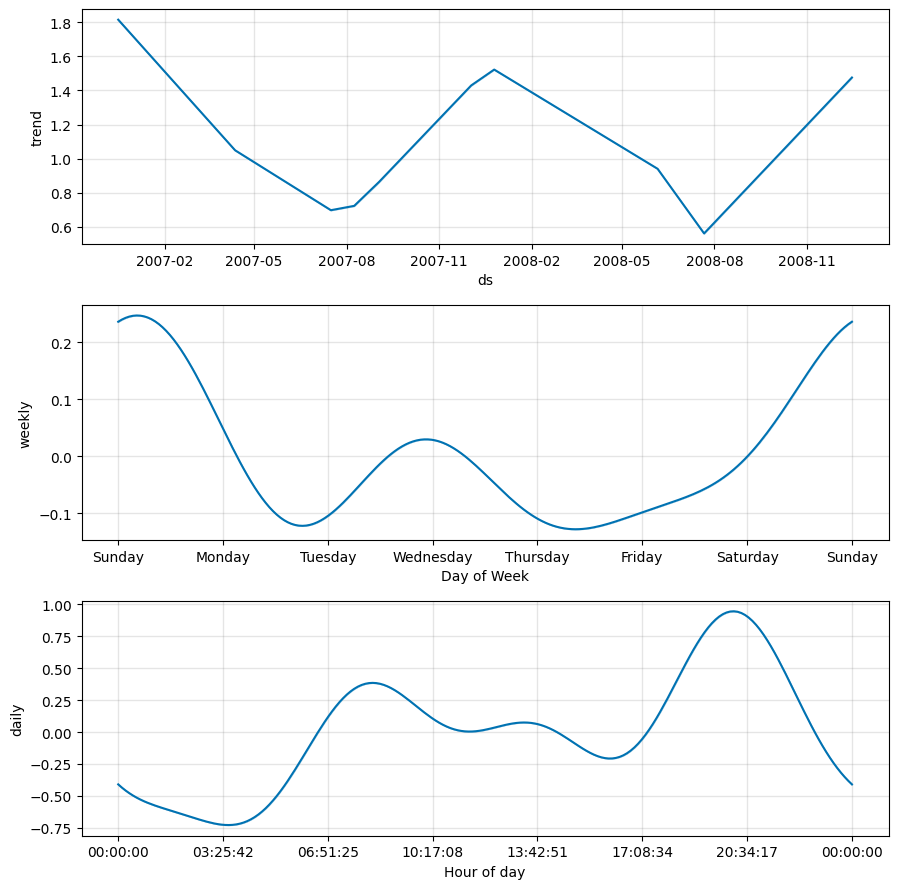

In [73]:
import pandas as pd
from prophet import Prophet
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data (auto-detect delimiter), fix headers
df = pd.read_csv("household power consumption.csv", sep=None, engine="python")
df.columns = df.columns.str.strip().str.lower()

# Build datetime + numeric target
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], dayfirst=True, errors="coerce")
df["global_active_power"] = pd.to_numeric(df["global_active_power"], errors="coerce")

# Resample hourly and format for Prophet
df = df.set_index("datetime")["global_active_power"].resample("H").mean().dropna().reset_index()
df = df.rename(columns={"datetime": "ds", "global_active_power": "y"})

# Fit Prophet
m = Prophet(daily_seasonality=True)
m.fit(df)

# Forecast next 48 hours
future = m.make_future_dataframe(periods=48, freq="h")
forecast = m.predict(future)

# Evaluate (last 48 hours as test)
y_true, y_pred = df["y"].tail(48).values, forecast["yhat"].tail(48).values
print("MAE:", mean_absolute_error(y_true, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))

# Plot
m.plot(forecast)
m.plot_components(forecast)

# ... Prophet training code ...

# Evaluate (last 48 hours as test)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = df["y"].tail(48).values
y_pred = forecast["yhat"].tail(48).values

prophet_mae = mean_absolute_error(y_true, y_pred)
prophet_rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("Prophet MAE:", prophet_mae)
print("Prophet RMSE:", prophet_rmse)

XGBoost MAE: 0.4577153685004411
XGBoost RMSE: 0.6195646069232389


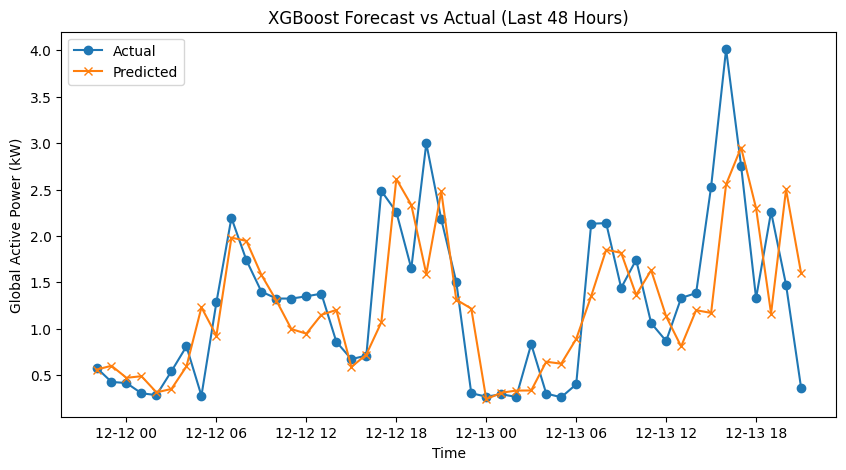

XGBoost MAE: 0.4577153685004411
XGBoost RMSE: 0.6195646069232389


In [74]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1) Load + clean dataset
df = pd.read_csv("household power consumption.csv", sep=None, engine="python")
df.columns = df.columns.str.strip().str.lower()

df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], dayfirst=True, errors="coerce")
df["global_active_power"] = pd.to_numeric(df["global_active_power"], errors="coerce")

# 2) Resample hourly
df = df.set_index("datetime")["global_active_power"].resample("h").mean().dropna().to_frame()

# 3) Create lag features
N_LAGS = 24  # use past 24 hours to predict next
for lag in range(1, N_LAGS + 1):
    df[f"lag_{lag}"] = df["global_active_power"].shift(lag)

df = df.dropna()

# 4) Train/test split (last 48 hours as test)
train, test = df.iloc[:-48], df.iloc[-48:]
X_train, y_train = train.drop("global_active_power", axis=1), train["global_active_power"]
X_test, y_test = test.drop("global_active_power", axis=1), test["global_active_power"]

# 5) Train XGBoost
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# 6) Predict
y_pred = model.predict(X_test)

# 7) Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("XGBoost MAE:", mae)
print("XGBoost RMSE:", rmse)

# 8) Plot actual vs forecast
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label="Actual", marker="o")
plt.plot(y_test.index, y_pred, label="Predicted", marker="x")
plt.legend()
plt.title("XGBoost Forecast vs Actual (Last 48 Hours)")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.show()

# ... XGBoost training code ...

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("XGBoost MAE:", xgb_mae)
print("XGBoost RMSE:", xgb_rmse)

In [75]:
import pandas as pd

results = {
    "Model": ["ARIMA", "Prophet", "XGBoost"],
    "MAE":   [arima_mae, prophet_mae, xgb_mae],
    "RMSE":  [arima_rmse, prophet_rmse, xgb_rmse],
}

df_results = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(df_results)

best_model = df_results.sort_values("RMSE").iloc[0]
print(f"\nBest Model: {best_model['Model']} "
      f"(RMSE={best_model['RMSE']:.4f}, MAE={best_model['MAE']:.4f})")


Model Performance Comparison:
     Model       MAE      RMSE
0    ARIMA  0.688472  0.902055
1  Prophet  0.658395  0.828938
2  XGBoost  0.457715  0.619565

Best Model: XGBoost (RMSE=0.6196, MAE=0.4577)


In [76]:
import os
print(os.getcwd())

C:\Users\ait
